# 1. Introduction

# 2. Research Question

**Which London wards have socio-demographic characteristics that may be linked to higher rates of deliberate fires?**

# 3. Presentation of data

### Import necessary packages

In [251]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from esda.adbscan import ADBSCAN

from sklearn import metrics

import warnings

import libpysal
from spopt.region import MaxPHeuristic as MaxP

## 3.1 Where it comes from

## 3.2 Load Data and Preprocessing

In [189]:
# Load original data
file_path = 'Data/Wards-profiles.csv'
df = pd.read_csv(file_path, na_values=['n/a'])

In [190]:
# Check basic info of dataframe to know which column might need to be handle
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 9 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Ward name                                          658 non-null    object 
 1   New code                                           658 non-null    object 
 2   Population density (persons per sq km) - 2013      658 non-null    object 
 3   In employment (16-64) - 2011                       658 non-null    float64
 4   Employment rate (16-64) - 2011                     658 non-null    float64
 5   Median House Price (£) - 2014                      658 non-null    object 
 6   Average GCSE capped point scores - 2014            658 non-null    float64
 7   A-Level Average Point Score Per Student - 2013/14  658 non-null    float64
 8   Deliberate Fires per 1,000 population - 2014       647 non-null    float64
dtypes: float64(

In [191]:
# Rename columns
df.columns = ['ward_name', 'new_code', 'pop_density', 'employment_number', 'employment_rate', 'house_price', 'avg_GCSE', 'avg_A_level', 'deliberate_fires']

In [192]:
# Check last 5 rows of dataframe
df.tail()

,ward_name,new_code,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires
654,Tower Hamlets,E09000030,"12,565",119774.0,63.6,"£383,000",315.0,667.1,1.2
655,Waltham Forest,E09000031,"6,897",118931.0,67.0,"£320,000",317.0,676.0,0.5
656,Wandsworth,E09000032,"8,854",175423.0,76.6,"£532,500",326.0,698.7,0.3
657,Westminster,E09000033,"10,286",107239.0,66.1,"£875,000",330.0,680.5,0.2
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
# Delete last row of NaN
df = df[:-1]

In [194]:
# Check transformation successful or not
df.tail()

,ward_name,new_code,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires
653,Sutton,E09000029,"4,480",94912.0,76.0,"£285,000",342.0,738.6,0.4
654,Tower Hamlets,E09000030,"12,565",119774.0,63.6,"£383,000",315.0,667.1,1.2
655,Waltham Forest,E09000031,"6,897",118931.0,67.0,"£320,000",317.0,676.0,0.5
656,Wandsworth,E09000032,"8,854",175423.0,76.6,"£532,500",326.0,698.7,0.3
657,Westminster,E09000033,"10,286",107239.0,66.1,"£875,000",330.0,680.5,0.2


In [195]:
# Transform data in 'pop_density' and 'house_price' from string to float type
df['pop_density'] = df['pop_density'].str.replace(',', '').astype(int)
df['house_price'] = df['house_price'].str.replace('£', '').str.replace(',', '').astype(int)

In [196]:
# Handle na value
# Store processed data into a new dataframe
df_drop_na = df.copy()
target_column = 'deliberate_fires'
df_drop_na[target_column] = df[target_column].fillna(df[target_column].median())

In [197]:
df_drop_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward_name          658 non-null    object 
 1   new_code           658 non-null    object 
 2   pop_density        658 non-null    int64  
 3   employment_number  658 non-null    float64
 4   employment_rate    658 non-null    float64
 5   house_price        658 non-null    int64  
 6   avg_GCSE           658 non-null    float64
 7   avg_A_level        658 non-null    float64
 8   deliberate_fires   658 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 46.4+ KB


In [198]:
df_drop_na.shape

(658, 9)

In [79]:
# Load shape file for plotting
london_shape = gpd.read_file("Data/ESRI/London_Ward.shp")
print(london_shape.crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [147]:
# Change Coordinate Reference System to widely used World Geodetic System 1984 (EPSG:4326)
london_shape = london_shape.to_crs(epsg=4326)
print(london_shape.crs)

EPSG:4326


In [81]:
london_shape.shape

(649, 8)

In [82]:
london_shape.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH',
       'POLY_ID', 'geometry'],
      dtype='object')

### 3.3 Merge two dataframes

In [199]:
# Merge two into target dataframe
# Here use london_shape as main dataframe because it is Geo dataframe
ppd = pd.merge(london_shape, df_drop_na, left_on='GSS_CODE', right_on='new_code', how='inner').reset_index()
ppd.shape

(624, 18)

In [200]:
ppd.head()

,index,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,ward_name,new_code,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires
0,0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",Kingston upon Thames - Chessington South,E05000405,1375,5291.0,78.5,315000,321.0,643.4,0.6
1,1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606...",Kingston upon Thames - Tolworth and Hook Rise,E05000414,3962,4993.0,76.2,337195,338.0,714.3,0.7
2,2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252...",Kingston upon Thames - Berrylands,E05000401,6467,4813.0,74.8,361125,343.0,733.7,0.3
3,3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838...",Kingston upon Thames - Alexandra,E05000400,3537,4464.0,75.1,404975,353.0,762.2,0.3
4,4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921...",Kingston upon Thames - Beverley,E05000402,5447,4807.0,71.6,435000,372.0,761.5,0.7


In [201]:
# Identify range and possible outliers in deliberate_fires column
ppd[ppd.deliberate_fires.isin([ppd.deliberate_fires.max(), ppd.deliberate_fires.min()])][['index','new_code','NAME','deliberate_fires']]

,index,new_code,NAME,deliberate_fires
27,27,E05000148,Bensham Manor,0.0
45,45,E05000127,West Wickham,0.0
135,135,E05000334,Manor,0.0
136,136,E05000329,Eastcote and East Ruislip,0.0
173,173,E05000101,Sudbury,0.0
175,175,E05000092,Kensal Green,0.0
231,231,E05000554,Village,0.0
300,300,E05000082,St. Michael's,0.0
301,301,E05000068,Brampton,0.0
341,341,E05000597,Hale End and Highams Park,0.0


### 3.4 Raw Distribution of data

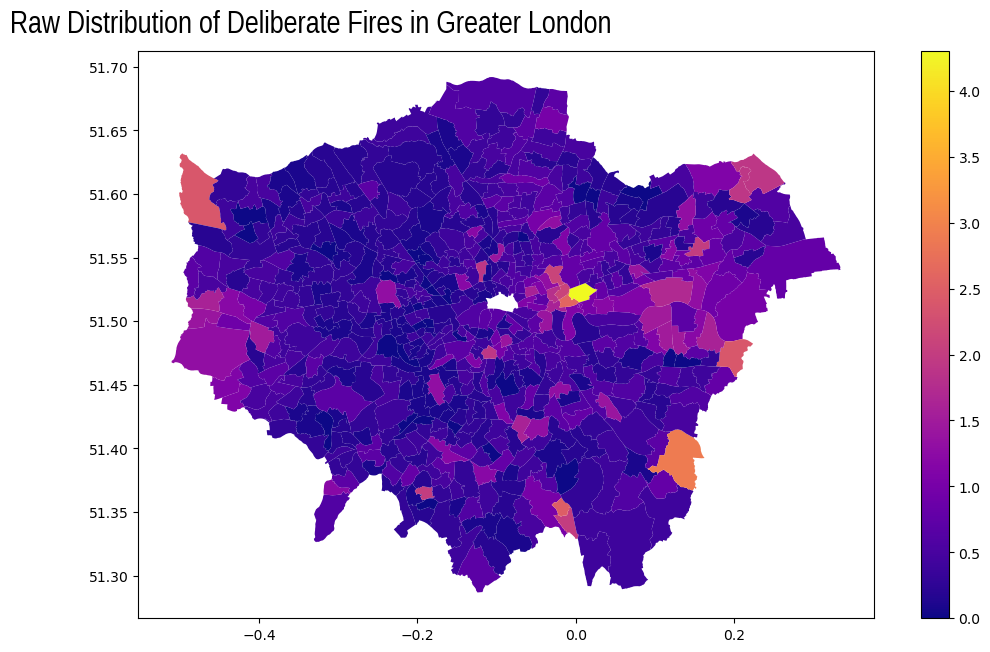

In [159]:
# Plot spatial distribution of deliberate fire in dataframe
# Set configurations of plot
f = plt.figure()
f.set_size_inches(12,7)
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

ax1 = f.add_subplot()
ppd.plot(column='deliberate_fires', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Raw Distribution of Deliberate Fires in Greater London", x=0.025, size=22, **tfont);

In [160]:
ppd.columns

Index(['index', 'NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD',
       'BOROUGH', 'POLY_ID', 'geometry', 'ward_name', 'new_code',
       'pop_density', 'employment_number', 'employment_rate', 'house_price',
       'avg_GCSE', 'avg_A_level', 'deliberate_fires'],
      dtype='object')

In [202]:
# Take some target columns out
raw = ppd[['new_code','pop_density','employment_number', 'employment_rate','house_price', 'avg_GCSE', 'avg_A_level', 'deliberate_fires']].set_index('new_code').copy()
raw.head()

,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires
new_code,,,,,,,
E05000405,1375,5291.0,78.5,315000,321.0,643.4,0.6
E05000414,3962,4993.0,76.2,337195,338.0,714.3,0.7
E05000401,6467,4813.0,74.8,361125,343.0,733.7,0.3
E05000400,3537,4464.0,75.1,404975,353.0,762.2,0.3
E05000402,5447,4807.0,71.6,435000,372.0,761.5,0.7


In [203]:
# Make sure they all numeric data so that can be used in following methods
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, E05000405 to E05000037
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_density        624 non-null    int64  
 1   employment_number  624 non-null    float64
 2   employment_rate    624 non-null    float64
 3   house_price        624 non-null    int64  
 4   avg_GCSE           624 non-null    float64
 5   avg_A_level        624 non-null    float64
 6   deliberate_fires   624 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.0+ KB


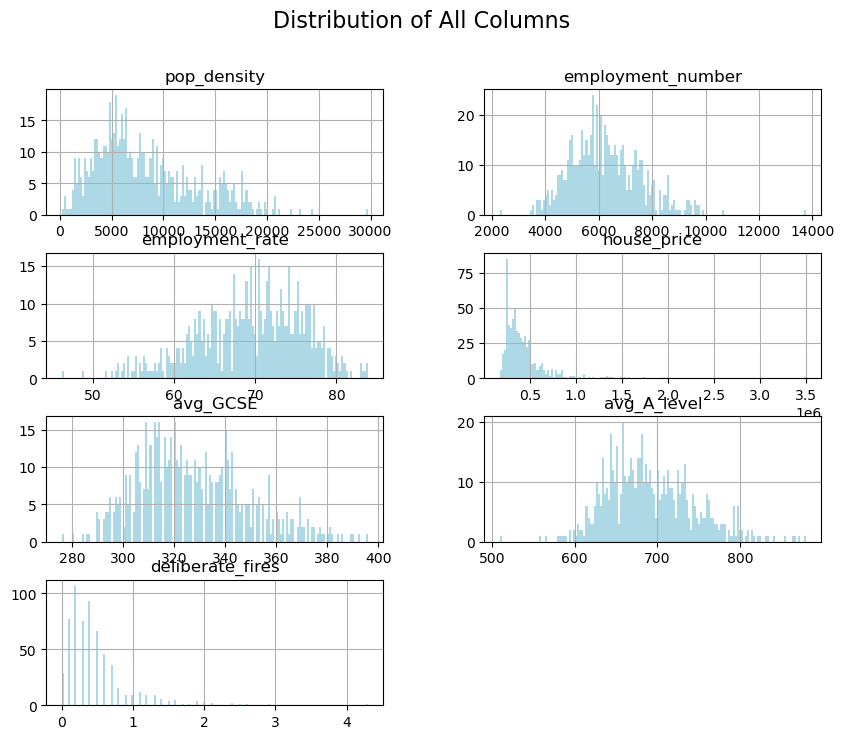

In [205]:
# Plot distribution of all columns
ax = raw.hist(bins=150, layout=(4,2), figsize=(10, 8), color='lightblue')

# Add a title
plt.suptitle('Distribution of All Columns', fontsize=16)
plt.show()

In [258]:
# Becasue the value in all column are >0 or =0.
raw_log = raw.copy()
target_columns_log = ['employment_number', 'employment_rate', 'avg_GCSE', 'avg_A_level']

# Log transformation
raw_log[target_columns_log] = raw_log[target_columns_log].apply(lambda x: np.log(x + 0.01))  # In order to avoid log(0), using x+0.01 here

# Box-Cox transformation
# stats.boxcox requires data must be 1-dimensional, so we have to handle those two columns separately
raw_log['pop_density'], fitted_lambda = stats.boxcox(raw_log['pop_density'])
raw_log['house_price'], fitted_lambda = stats.boxcox(raw_log['house_price'])


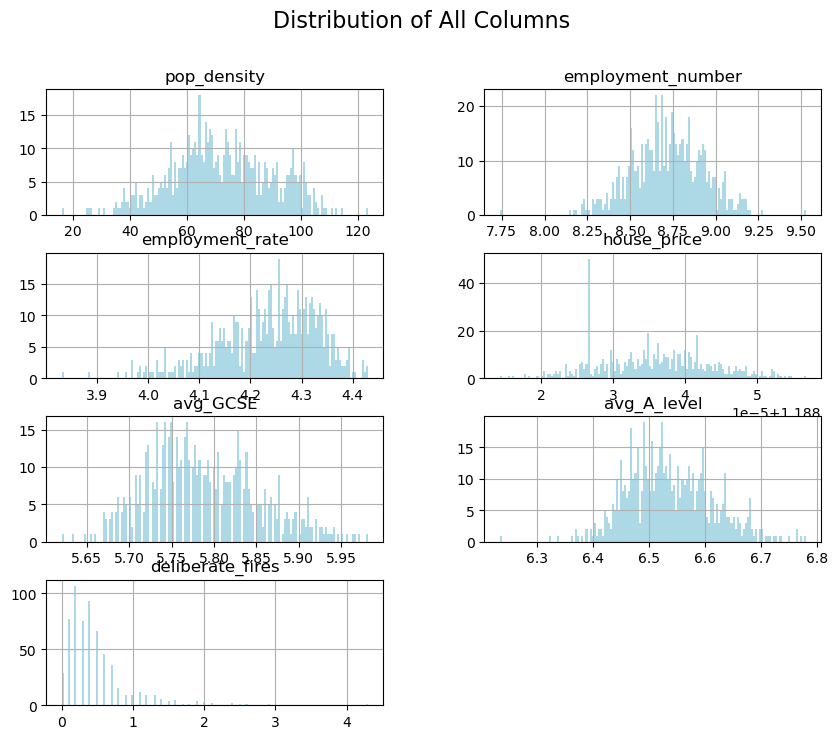

In [259]:
# Plot distribution of all columns after log and box-cox transformation
ax = raw_log.hist(bins=150, layout=(4,2), figsize=(10, 8), color='lightblue')

# Add a title
plt.suptitle('Distribution of All Columns', fontsize=16)
plt.show()

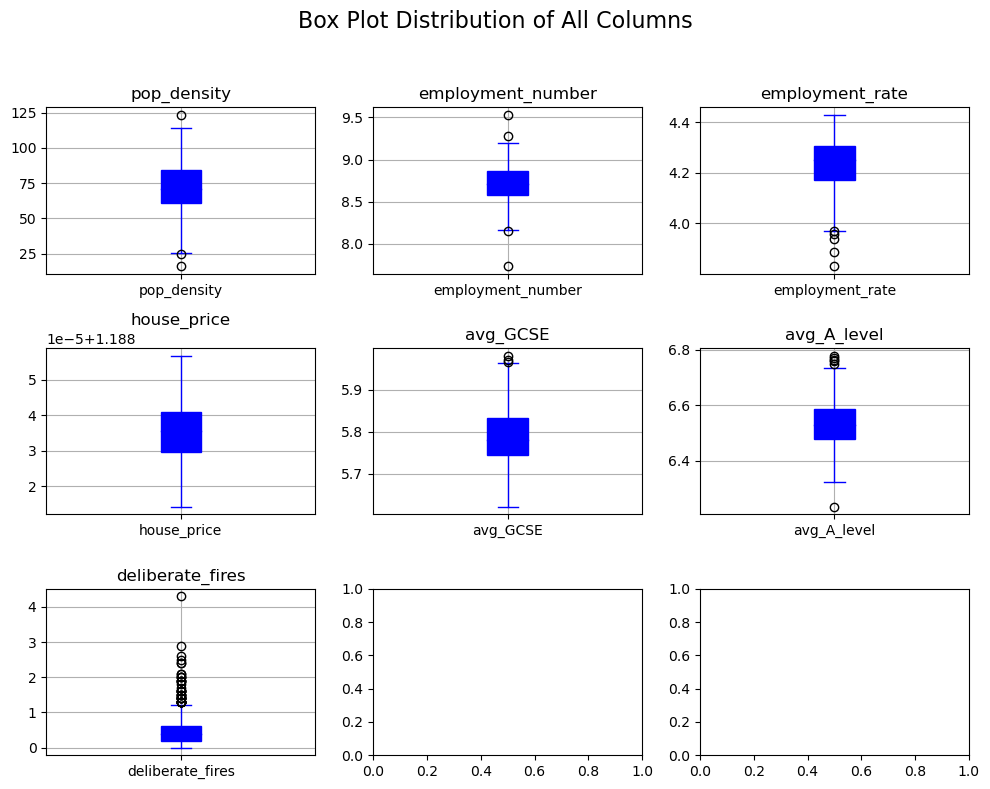

In [260]:
# Set configurations of plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
axes = axes.flatten()

# Plot box plot for each column
for i, column in enumerate(raw_log.columns):
    raw_log.boxplot(column=column, ax=axes[i], color='blue', patch_artist=True)
    axes[i].set_title(column)

# Add a title
plt.suptitle('Box Plot Distribution of All Columns', fontsize=16)

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [261]:
# Normalise by using IQR and median value to avoid outliers
rs = RobustScaler(quantile_range=(10.0, 90.0))

# Initiate a new dataframe to store change
normed = raw_log.copy()

for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of pop_density is [-0.527941966684578, 1.7418822445689717]
The range of employment_number is [-1.1561570674273227, 2.32323845360199]
The range of employment_rate is [-1.4783950617283954, 0.8549382716049377]
The range of house_price is [-0.4321793416572075, 7.120601589103288]
The range of avg_GCSE is [-0.8727272727272727, 1.309090909090909]
The range of avg_A_level is [-1.3302261613691935, 1.497555012224939]
The range of deliberate_fires is [-0.4444444444444445, 4.333333333333333]


,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires
new_code,,,,,,,
E05000405,-0.436286,-0.246404,0.521605,-0.109818,-0.054545,-0.307916,0.222222
E05000414,-0.237699,-0.336833,0.379630,-0.059432,0.254545,0.233802,0.333333
E05000401,-0.045406,-0.391455,0.293210,-0.005108,0.345455,0.382029,-0.111111
E05000400,-0.270323,-0.497360,0.311728,0.094438,0.527273,0.599786,-0.111111
E05000402,-0.123705,-0.393275,0.095679,0.162599,0.872727,0.594438,0.333333


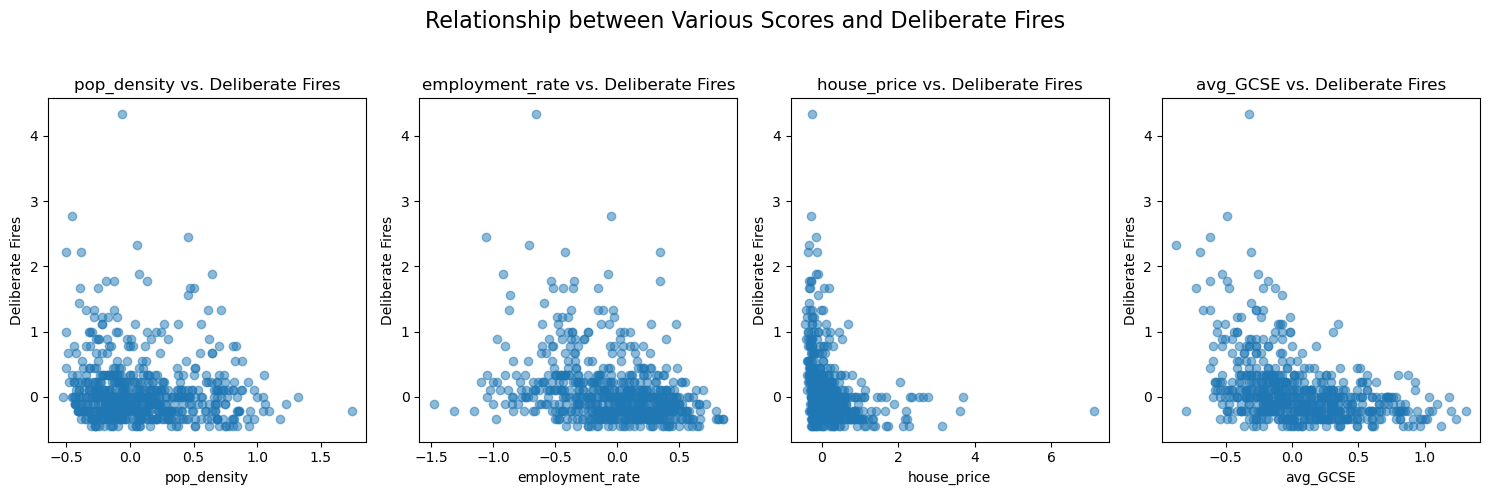

In [224]:
# List all the columns that we want to make scatter polt with deliberate_fires
columns_to_plot = ['pop_density', 'employment_rate', 'house_price', 'avg_GCSE']

# Set configurations of plot
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, len(columns_to_plot), i)
    plt.scatter(normed[column], normed['deliberate_fires'], alpha=0.5)
    plt.title(f'{column} vs. Deliberate Fires')
    plt.xlabel(column)
    plt.ylabel('Deliberate Fires')

# Add a title
plt.suptitle('Relationship between Various Scores and Deliberate Fires', fontsize=16)

# Adjust layout to avoid overlapping 
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


## 4. Methodology

### 4.1 Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [92]:
def mapping_clusters(labels_cluster):
    ppd['cluster_nm'] = labels_cluster
    ppd.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [131]:
# Adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # Parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # Add an additional element to both categories and restaurants that’s identical to the first item
    # Manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

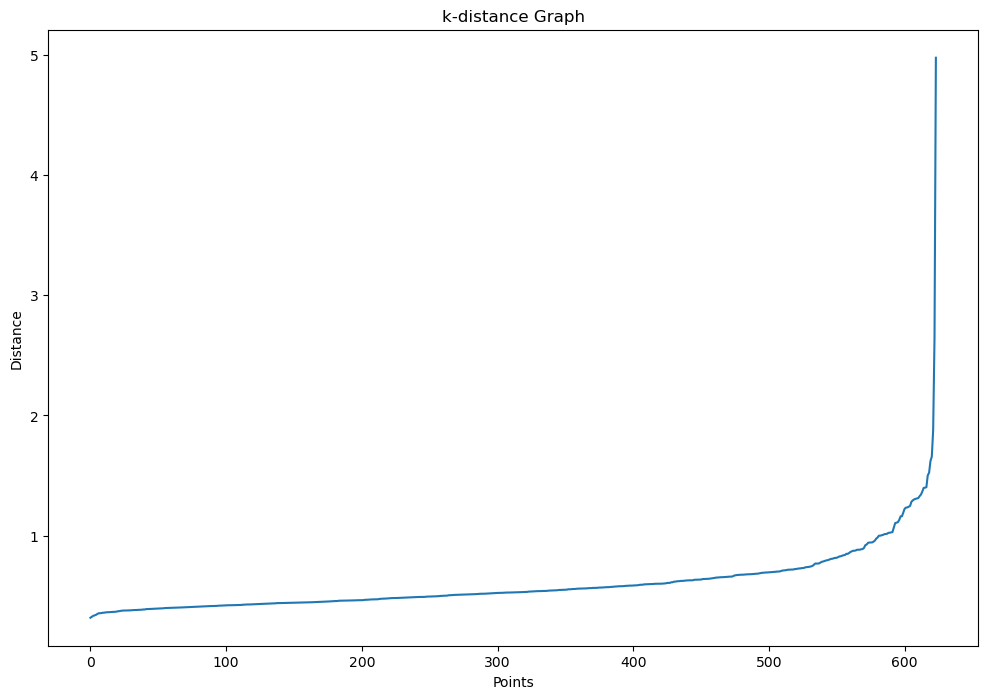

In [132]:
# Apply NearestNeighbors to calculate k-dist
min_samples = 9
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(normed)
distances, indices = neigh.kneighbors(normed)

# Extract the distance of every point to nearest min_samples
k_dist = distances[:, min_samples-1]

# Plot K-dist figure
plt.plot(np.sort(k_dist))
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('k-distance Graph')
plt.show()


### 4.2 Max-P

In [119]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [120]:
attrs_name = normed.columns.values.tolist()
attrs_name

['pop_density',
 'employment_number',
 'employment_rate',
 'house_price',
 'avg_GCSE',
 'avg_A_level',
 'deliberate_fires']

In [123]:
w = libpysal.weights.Queen.from_dataframe(ppd)

In [124]:
threshold = 0.2 * normed.shape[0]
print(threshold)
camden_copy = normed.copy()
camden_copy["count"] = 1
threshold_name = "count"

124.80000000000001


* Here is the configuration of the computer that I am currently using:
- **Processor**: *2.6 GHz 6-Core Intel Core i7*
- **Graphics**: *Intel UHD Graphics 630 1536 MB*
- **Memory**: *16 GB 2400 MHz DDR4*

In [125]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(camden_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 9h 27min 30s, sys: 17.1 s, total: 9h 27min 48s
Wall time: 9h 27min 39s


## 5. Restlt and Discussion

### 5.1 Result of DBSCAN

7


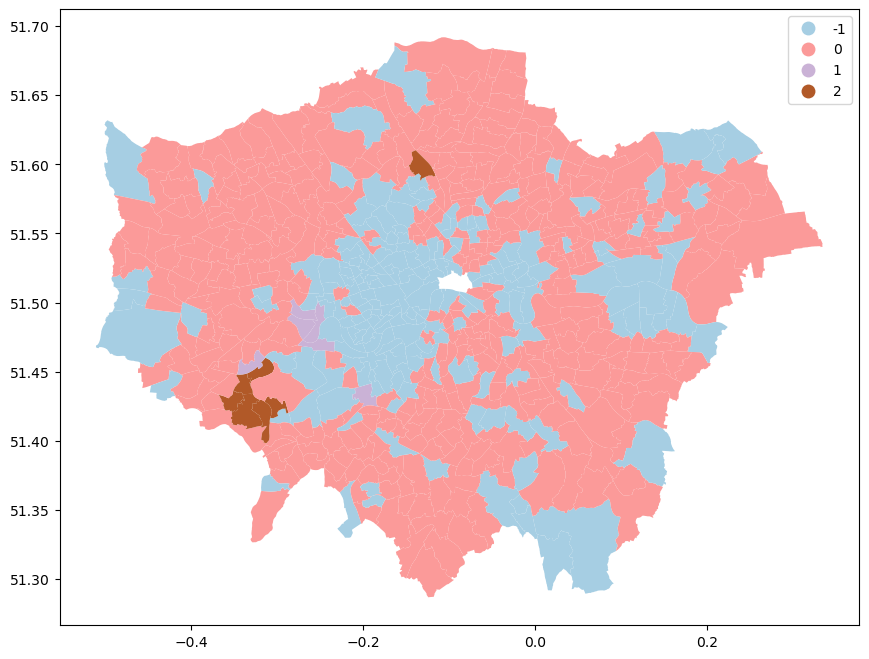

In [133]:
# Find a proper minPts by how may features dataset got
print(normed.shape[1])

# Set minPts as normed.shape[1] + 1 
minPts = 8 

# According to K-dist map, set epsilon=1 first
# Result shows that there only 2 clusters, hence we reduce the minimun distance between clusters
epsilon = 0.5

# Configure hyper parameters using minPts and epsilon, then fit model
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

# Visualise the result
mapping_clusters(cluster_nm)

### 5.2 Evaluation of DBSCAN

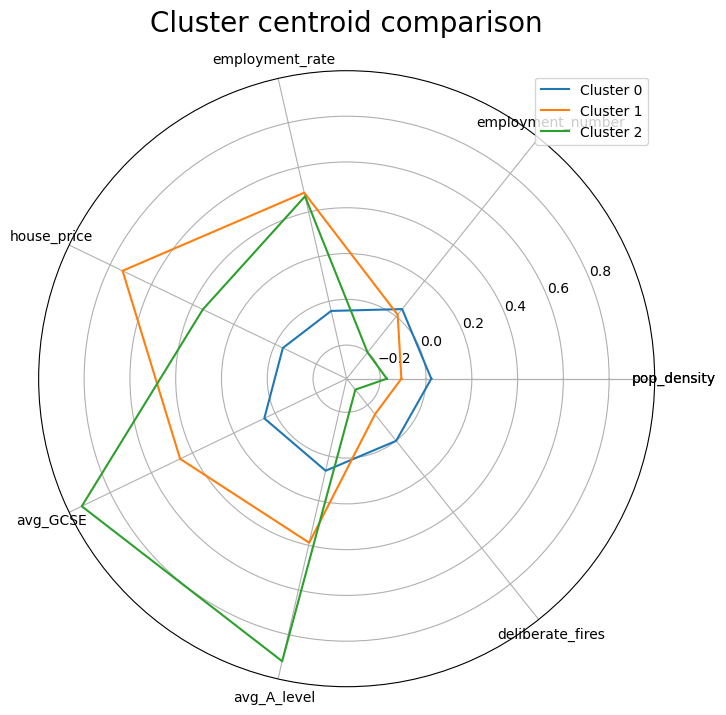

In [225]:
# Initiate a new dataframe to store change
df_dbscan = normed.copy()

# Store result labels
df_dbscan['cluster'] = dbsc.labels_

# Calculate centroids
df_dbscan_centroid = df_dbscan.groupby('cluster').mean()

# drop the outlier
df_dbscan_centroid.drop(-1, inplace=True)

# Plot radar figure via "radar_plot_cluster_centroids" function
radar_plot_cluster_centroids(df_dbscan_centroid)

In [227]:
# Calculate silhouette score to evaluate performance
metrics.silhouette_score(normed, dbsc.labels_)

0.0016974266576658182

### 5.3 Result of Max-P

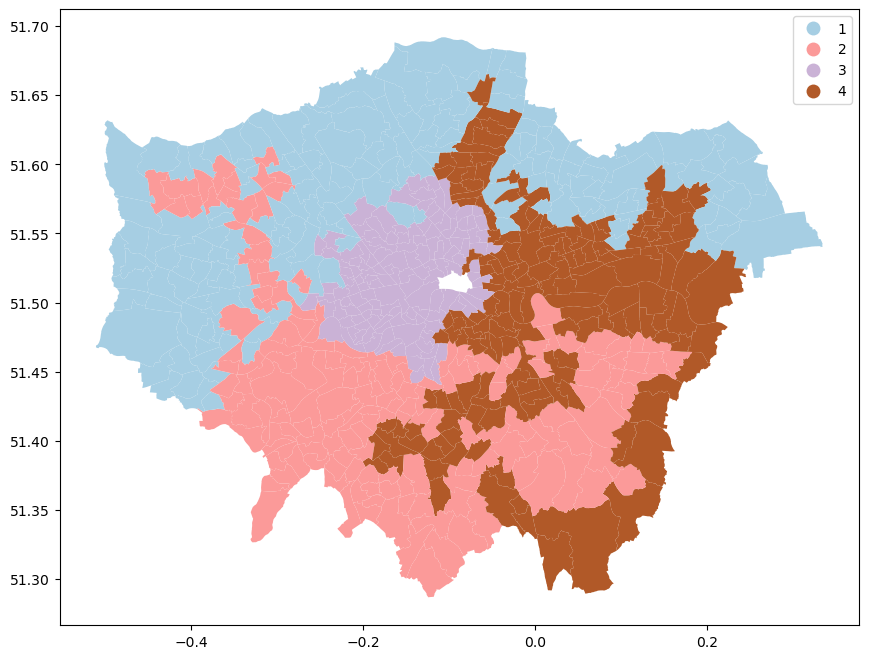

In [128]:
# Visualise the output of Max-p method
ppd['cluster_max_p'] = model.labels_
ppd.plot(column='cluster_max_p', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

### 5.4 Evaluation of Max-P

In [233]:
camden_copy.head()

,pop_density,employment_number,employment_rate,house_price,avg_GCSE,avg_A_level,deliberate_fires,count,cluster_max_p
new_code,,,,,,,,,
E05000405,-0.436286,-0.246404,0.521605,-0.109818,-0.054545,-0.307916,0.222222,1,2
E05000414,-0.237699,-0.336833,0.379630,-0.059432,0.254545,0.233802,0.333333,1,2
E05000401,-0.045406,-0.391455,0.293210,-0.005108,0.345455,0.382029,-0.111111,1,2
E05000400,-0.270323,-0.497360,0.311728,0.094438,0.527273,0.599786,-0.111111,1,2
E05000402,-0.123705,-0.393275,0.095679,0.162599,0.872727,0.594438,0.333333,1,2


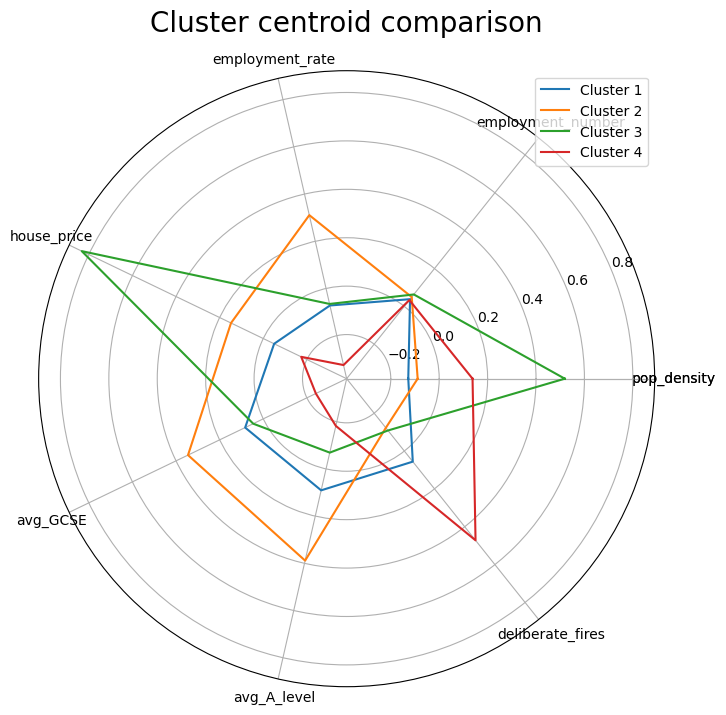

In [235]:
# Initiate a new dataframe to store change
df_max_p = camden_copy.copy()

# Due to Max-p will generate a new column named as "count",
# which will effet quaity of radar plot.
# We need to delete it first
df_max_p = df_max_p.drop('count', axis=1)

# Store result labels
df_max_p['cluster_max_p'] = model.labels_

# Calculate centroids
df_max_p_centroid = df_max_p.groupby('cluster_max_p').mean()

# Plot radar figure via "radar_plot_cluster_centroids" function
radar_plot_cluster_centroids(df_max_p_centroid)

In [130]:
metrics.silhouette_score(camden_copy, model.labels_)

0.041847235230313445

### 5.5 Discussion

## 6. Conclusion

## 7. Reference List